In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from glob import glob
from collections import Counter
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso

from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score, classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef

from imblearn.over_sampling import RandomOverSampler

In [2]:
feature_list = torch.load(f"./radiomics_features_RADCURE_new2.pt")
subjects = torch.load(f"./subjects_RADCURE_new2.pt")
labels = [hpv_status.split("/")[-1].split("_")[-1].split(".")[0] for hpv_status in glob("../../data/RADCURE//volume+seg/*label*")]

keys = [key for key in feature_list[0].keys() if key.startswith("original")]
keys.extend([key for key in feature_list[0].keys() if key.startswith("wavelet")])
keys.extend([key for key in feature_list[0].keys() if key.startswith("log")])
print(f"Num of features: {len(keys)}")
data = {}
   
for i in tqdm(range(len(feature_list))):
    features = feature_list[i]

    data_features = {}
    for feature_name in keys:
        data_features[feature_name] = features[feature_name].item()
        data[i] = data_features

df = pd.DataFrame(data).transpose()
df["subject"] = subjects
df["hpv_status"] = labels
df["label"] = [0 if "negative" in hpv_status else 1 for hpv_status in df.hpv_status]
df.hpv_status.value_counts()

Num of features: 1246


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1204/1204 [00:00<00:00, 4140.28it/s]


hpv_status
hpv-positive    880
hpv-negative    324
Name: count, dtype: int64

In [16]:
values = df.to_numpy()
X = values[:, :-3]
y = values[:, -1]
y = y.astype(int)

print(X.shape)

(1204, 1246)


In [17]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)                                                        
X_train = np.concatenate([X_train, X_val], axis=0)
y_train = np.concatenate([y_train, y_val], axis=0)

In [18]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Feature Selection: LASSO

Best Alpha: 0.04
Num remaining feaures: 0


/home/johannes/anaconda3/envs/virtualbiopsy/lib/python3.9/site-packages/sklearn/feature_selection/_base.py:102: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
/home/johannes/anaconda3/envs/virtualbiopsy/lib/python3.9/site-packages/sklearn/feature_selection/_base.py:102: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(


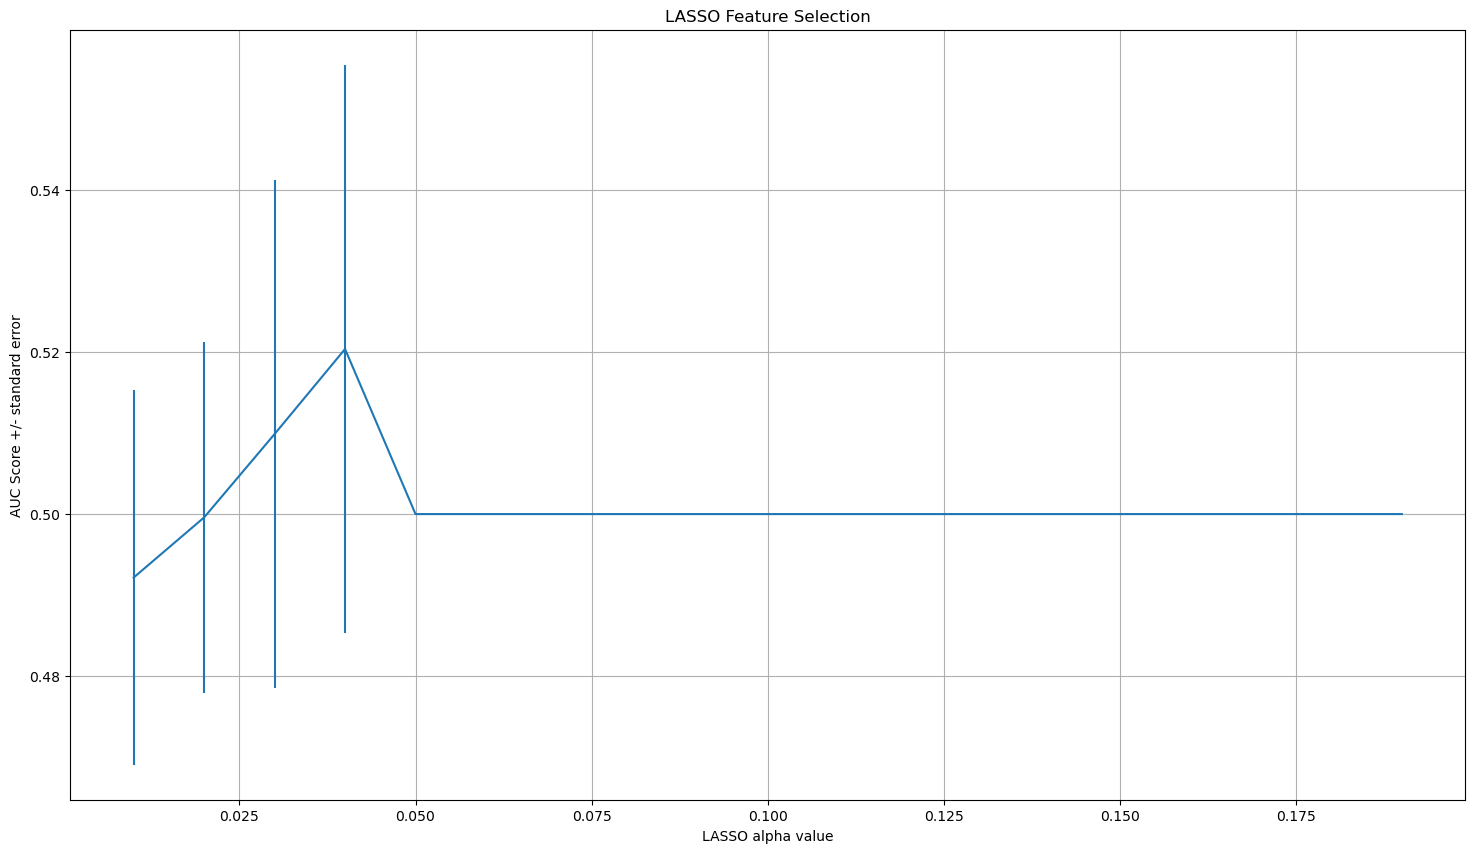

In [15]:
alpha_range = np.arange(0.01, 0.2, 0.01)
search = GridSearchCV(Lasso(),
                      {'alpha': alpha_range},
                      cv = 5, 
                      scoring="roc_auc",verbose=0
                      )

search.fit(X_train,y_train)
best_alpha = list(search.best_params_.values())[0]
print(f"Best Alpha: {best_alpha}")

sel_ = SelectFromModel(Lasso(alpha=best_alpha, random_state=42))
sel_.fit(X_train, y_train)
X_train = sel_.transform(X_train)
X_test = sel_.transform(X_test)

print(f"Num remaining feaures: {X_train.shape[1]}")

plt.figure(figsize=(18,10))
plt.errorbar(alpha_range, search.cv_results_["mean_test_score"], yerr=search.cv_results_["std_test_score"])
plt.xlabel("LASSO alpha value")
plt.ylabel("AUC Score +/- standard error")
plt.title("LASSO Feature Selection")
plt.grid()
plt.show()

### Feature Selection: PCA

Num remaining feaures: 136


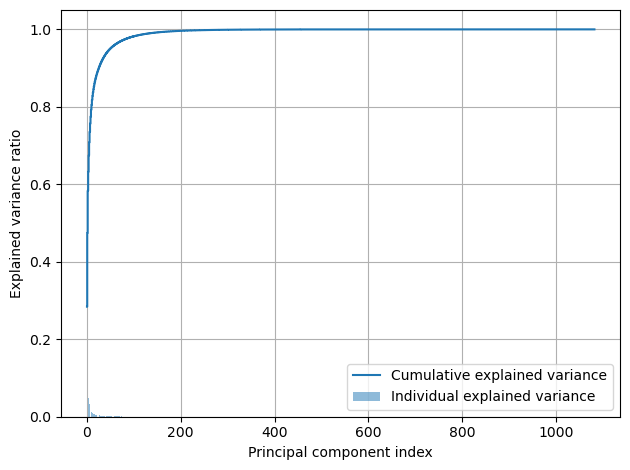

In [19]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

pca = PCA()
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

threshold = 0.99
num_components_to_keep = None

for idx, var_expl in enumerate(cum_sum_eigenvalues):
    if var_expl > threshold:
        num_components_to_keep = idx+1
        break        
        
print(f"Num remaining feaures: {num_components_to_keep}")

X_train = X_train[:, :num_components_to_keep]
X_test = X_test[:, :num_components_to_keep]

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.grid()
plt.show()

### Random Oversampling

In [20]:
print(f"Before: {Counter(y_train)}")

oversample = RandomOverSampler(sampling_strategy='minority', random_state=42)
X_train, y_train = oversample.fit_resample(X_train, y_train)

print(f"After:  {Counter(y_train)}")

Before: Counter({1: 802, 0: 281})
After:  Counter({0: 802, 1: 802})


### Support Vector Machine

In [21]:
svc = SVC(probability=True, random_state=42)

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'gamma': [100, 10, 1, 0.1, 0.01, 0.001],
              'kernel': ['rbf', 'poly', 'linear']
              }

#svc = GridSearchCV(svc, param_grid, refit = True, verbose = 0, scoring='roc_auc')
svc.fit(X_train, y_train)

y_pred_train = svc.predict(X_train)
y_pred_test = svc.predict(X_test)
y_prob_train = svc.predict_proba(X_train)
y_prob_test = svc.predict_proba(X_test)

cm = confusion_matrix(y_test, y_pred_test)
tn, fp, fn, tp = cm.ravel()

print(f"Train ACC: {svc.score(X_train, y_train):.2f}")
print(f"Test  ACC: {svc.score(X_test, y_test):.2f}\n")

print(f"Train Balanced ACC: {balanced_accuracy_score(y_train, y_pred_train):.2f}")
print(f"Test  Balanced ACC: {balanced_accuracy_score(y_test, y_pred_test):.2f}\n")

print(f"Train AUC: {roc_auc_score(y_train, y_prob_train[:, 1]):.2f}")
print(f"Test  AUC: {roc_auc_score(y_test, y_prob_test[:, 1]):.2f}\n")

print(f"Test  Sensitivity: {tp / (tp + fn):.2f}")
print(f"Test  Specificity: {tn / (tn + fp):.2f}\n")

print(f"Train F1-Score: {f1_score(y_train, y_pred_train, average='macro'):.2f}")
print(f"Test  F1-Score: {f1_score(y_test, y_pred_test, average='macro'):.2f}\n")

print(f"Train MCC: {matthews_corrcoef(y_train, y_pred_train):.2f}")
print(f"Test  MCC: {matthews_corrcoef(y_test, y_pred_test):.2f}\n")


print("Confusion Matrix")
print(cm)

Train ACC: 0.68
Test  ACC: 0.50

Train Balanced ACC: 0.68
Test  Balanced ACC: 0.48

Train AUC: 0.79
Test  AUC: 0.48

Test  Sensitivity: 0.55
Test  Specificity: 0.42

Train F1-Score: 0.68
Test  F1-Score: 0.48

Train MCC: 0.37
Test  MCC: -0.03

Confusion Matrix
[[18 25]
 [35 43]]


### Random Forest

In [22]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

y_pred_train = rfc.predict(X_train)
y_pred_test = rfc.predict(X_test)
y_prob_train = rfc.predict_proba(X_train)
y_prob_test = rfc.predict_proba(X_test)

cm = confusion_matrix(y_test, y_pred_test)
tn, fp, fn, tp = cm.ravel()

print(f"Train ACC: {rfc.score(X_train, y_train):.2f}")
print(f"Test  ACC: {rfc.score(X_test, y_test):.2f}\n")

print(f"Train Balanced ACC: {balanced_accuracy_score(y_train, y_pred_train):.2f}")
print(f"Test  Balanced ACC: {balanced_accuracy_score(y_test, y_pred_test):.2f}\n")

print(f"Train AUC: {roc_auc_score(y_train, y_prob_train[:, 1]):.2f}")
print(f"Test  AUC: {roc_auc_score(y_test, y_prob_test[:, 1]):.2f}\n")

print(f"Test  Sensitivity: {tp / (tp + fn):.2f}")
print(f"Test  Specificity: {tn / (tn + fp):.2f}\n")

print(f"Train F1-Score: {f1_score(y_train, y_pred_train, average='macro'):.2f}")
print(f"Test  F1-Score: {f1_score(y_test, y_pred_test, average='macro'):.2f}\n")

print(f"Train MCC: {matthews_corrcoef(y_train, y_pred_train):.2f}")
print(f"Test  MCC: {matthews_corrcoef(y_test, y_pred_test):.2f}\n")

print("Confusion Matrix")
print(cm)

Train ACC: 1.00
Test  ACC: 0.64

Train Balanced ACC: 1.00
Test  Balanced ACC: 0.49

Train AUC: 1.00
Test  AUC: 0.62

Test  Sensitivity: 0.99
Test  Specificity: 0.00

Train F1-Score: 1.00
Test  F1-Score: 0.39

Train MCC: 1.00
Test  MCC: -0.07

Confusion Matrix
[[ 0 43]
 [ 1 77]]
